## Goal:
* Read classified sidewalk data from database
* Clean sidewalks
* Write the result back to the database

## Connect to Database and fetch the data using psycopg2:

In [3]:
import psycopg2

In [4]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"

Opened database successfully


* Fetch the data:  
each row including a polygon_id (b_id) and geometry (in geoJSON format) of all sidewalks within that polygon

In [5]:
cur = conn.cursor()
cur.execute("SELECT b_id,  st_asgeojson(ST_Collect(s_geom)) from grouped_sidewalks group by b_id")
rows = cur.fetchall()

* Each row of the fetched data looks like:

In [6]:
for row in rows:
    print row
    break

(1, '{"type":"MultiLineString","coordinates":[[[1255276.99133064,194138.403187305],[1255075.26469998,193527.346994713],[1255066.18433756,193398.133342385]],[[1255089.30240156,194300.672219723],[1254838.81701015,193538.456224471],[1254835.50369656,193517.105545387],[1254837.9656339,193499.805383131]],[[1255076.1321523,193404.484379545],[1255021.58764197,193413.560476884],[1254877.71063314,193461.121733472],[1254858.82976539,193471.062658474],[1254844.39213023,193486.04097496]],[[1255275.28234456,194132.847424135],[1255069.95828015,194291.478668556]]]}')


## Cleaning and Plotting Functions:

In [7]:
# Packages:
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def findTwoClosePointsIndex(twoLineList):
    # Takes twolines and gives the index of two close points (one from each line) 
    # in addition to the distance between them
    distances = []
 
    for i in range(2):
        for j in range(2):
            distances.append(Point(twoLineList[0][-i]).distance(Point(twoLineList[1][-j])))
            
    if distances.index(min(distances)) == 0:
            return [[0,0], min(distances)] 
    if distances.index(min(distances)) == 1:
            return [[0,1], min(distances)] 
    if distances.index(min(distances)) == 2:
            return [[1,0], min(distances)] 
    if distances.index(min(distances)) == 3:
            return [[1,1], min(distances)] 
        
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lines = deepcopy(twoLineList)
    disAndIndex = findTwoClosePointsIndex(lines)
    if disAndIndex[1] < tolClose:
        avgX = (lines[0][-disAndIndex[0][0]][0] + lines[1][-disAndIndex[0][1]][0])/float(2)
        avgY = (lines[0][-disAndIndex[0][0]][1] + lines[1][-disAndIndex[0][1]][1])/float(2)
        lines[0][-disAndIndex[0][0]] = [avgX, avgY]
        lines[1][-disAndIndex[0][1]] = [avgX, avgY]
    return lines

        
def findTwoClosePointFromgivenPointIndex(twoLineList, givenPoint):
    # Takes twolines and a given point gives the index of two closes points (one from each line)
    # a given point in addition to the distance between them
    shortDisGivenIndex = []
    for i in range(2):
        distances = []
        for j in range(2):
            distances.append(Point(twoLineList[i][-j]).distance(givenPoint))
        shortDisGivenIndex.append([distances.index(min(distances)), min(distances)])
    return shortDisGivenIndex
            

def cleanIfintesectedAlready(twoLineList, tolInt):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [intrsct.x, intrsct.y]
        return lines
    
    elif intrsct.geom_type == 'LineString':
        midPoint = intrsct.interpolate(intrsct.length/2)
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, midPoint)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [midPoint.x, midPoint.y]
        return lines
    
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            for i in range(2):
                if shortDisIndices[i][1] < tolInt:
                    lines[i][-shortDisIndices[i][0]] = [intPoint.x, intPoint.y]
        return lines    
def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
            lines[0][-shortDisIndices[0][0]] = [intrsct.x, intrsct.y]
            lines[1][-shortDisIndices[1][0]] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    elif intrsct.geom_type == 'LineString':
        return connectToAvgIfCloseEnough(lines, 10*tolInt) #Not by tolClose
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Extended version of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
                lines[0][-shortDisIndices[0][0]] = [intPoint.x, intPoint.y]
                lines[1][-shortDisIndices[1][0]] = [intPoint.x, intPoint.y]
        return lines

# Work on this else i.e. the case where the extended versions meet in form
# of MultiPoints very far and connectToAvgIfCloseEnough needs to be applied     
#             else:
#                 return connectToAvgIfCloseEnough(lines, tolClose)
        
            

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
    
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean
# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

* Clean one group to see if cleaning is working:
* Note: ast.literal_eval changes text to a dictionary

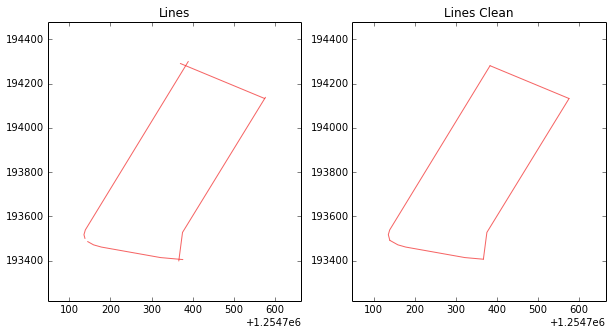

In [8]:
import ast
extL, tolInt, tolClose = 150, 35, 25
cleanSWList = []
for row in rows:
    group = ast.literal_eval(row[1])['coordinates']
    cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
    cleanSWList.append((row[0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    break
# Plot the results
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in group:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, group, "Lines")
ax = fig.add_subplot(122)
for line in cleanSWList[0][1]['coordinates']:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, group, "Lines Clean")

* Applying the cleaning to **n** polygons which have less than **m** number of sidewalks inside them:

In [15]:
n = 50
m = 100
extL, tolInt, tolClose = 150, 40, 35
SWProcessedList = []
cleanSWList = []
for i in range(n):
    group = ast.literal_eval(rows[i][1])['coordinates']
    if len(group) < 100:
        SWProcessedList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': group}))
        cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
        cleanSWList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    else:
        print rows[i][0],i

9 8
10 9
25 24
30 29
41 40
50 49


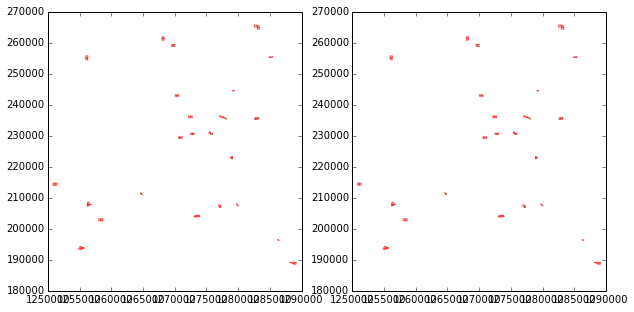

In [16]:
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for row in SWProcessedList:
    for line in row[1]['coordinates']:
        plot_line(ax, line, '#F22222')
# handle_axesLimTitle_for_lineList(ax, firstPol, "Lines")
ax = fig.add_subplot(122)
for element in cleanSWList:
    for line in element[1]['coordinates']:
        plot_line(ax, line, '#F22222')
# handle_axesLimTitle_for_lineList(ax, group, "Lines Clean")

## Create a table called "Amir_CleanSW" with two columns:
1. PolygonID: includes Polygon ID
2. SWwithinPolGeom: includes the geometry of all sidewalks within each polygon

In [17]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
# Delete the table if already exist
cur.execute('''DROP TABLE IF EXISTS Amir_CleanSW''')
# Create table CleanSW
cur.execute('''CREATE TABLE Amir_CleanSW (PolygonID INT, SWwithinPolGeom geometry(MULTILINESTRING, 2926));''')
print "Table created"
conn.commit()
conn.close()

Opened database successfully
Table created


## Put clean data into the created table:

In [74]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute('''TRUNCATE Amir_CleanSW''')

for row in cleanSWList:
    cur = conn.cursor()

    cur.execute("INSERT INTO Amir_CleanSW (PolygonID, SWwithinPolGeom) \
                VALUES (%s, ST_SetSRID(ST_GeomFromGeoJSON(%s),2926))", (row[0], str(row[1])) );

    conn.commit()
conn.close()
print "Clean Data inserted successfully"

Opened database successfully
Clean Data inserted successfully


## Code:

In [18]:
# Packages:
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def findTwoClosePointsIndex(twoLineList):
    # Takes twolines and gives the index of two close points (one from each line) 
    # in addition to the distance between them
    distances = []
 
    for i in range(2):
        for j in range(2):
            distances.append(Point(twoLineList[0][-i]).distance(Point(twoLineList[1][-j])))
            
    if distances.index(min(distances)) == 0:
            return [[0,0], min(distances)] 
    if distances.index(min(distances)) == 1:
            return [[0,1], min(distances)] 
    if distances.index(min(distances)) == 2:
            return [[1,0], min(distances)] 
    if distances.index(min(distances)) == 3:
            return [[1,1], min(distances)] 
        
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lines = deepcopy(twoLineList)
    disAndIndex = findTwoClosePointsIndex(lines)
    if disAndIndex[1] < tolClose:
        avgX = (lines[0][-disAndIndex[0][0]][0] + lines[1][-disAndIndex[0][1]][0])/float(2)
        avgY = (lines[0][-disAndIndex[0][0]][1] + lines[1][-disAndIndex[0][1]][1])/float(2)
        lines[0][-disAndIndex[0][0]] = [avgX, avgY]
        lines[1][-disAndIndex[0][1]] = [avgX, avgY]
    return lines

        
def findTwoClosePointFromgivenPointIndex(twoLineList, givenPoint):
    # Takes twolines and a given point gives the index of two closes points (one from each line)
    # a given point in addition to the distance between them
    shortDisGivenIndex = []
    for i in range(2):
        distances = []
        for j in range(2):
            distances.append(Point(twoLineList[i][-j]).distance(givenPoint))
        shortDisGivenIndex.append([distances.index(min(distances)), min(distances)])
    return shortDisGivenIndex
            

def cleanIfintesectedAlready(twoLineList, tolInt):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [intrsct.x, intrsct.y]
        return lines
    
    elif intrsct.geom_type == 'LineString':
        midPoint = intrsct.interpolate(intrsct.length/2)
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, midPoint)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [midPoint.x, midPoint.y]
        return lines
    
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            for i in range(2):
                if shortDisIndices[i][1] < tolInt:
                    lines[i][-shortDisIndices[i][0]] = [intPoint.x, intPoint.y]
        return lines    
def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
            lines[0][-shortDisIndices[0][0]] = [intrsct.x, intrsct.y]
            lines[1][-shortDisIndices[1][0]] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    elif intrsct.geom_type == 'LineString':
        return connectToAvgIfCloseEnough(lines, tolInt) #Not by tolClose
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Extended version of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
                lines[0][-shortDisIndices[0][0]] = [intPoint.x, intPoint.y]
                lines[1][-shortDisIndices[1][0]] = [intPoint.x, intPoint.y]
        return lines

# Work on this else i.e. the case where the extended versions meet in form
# of MultiPoints very far and connectToAvgIfCloseEnough needs to be applied     
#             else:
#                 return connectToAvgIfCloseEnough(lines, tolClose)
        
            

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
    
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean
# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

In [19]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute("SELECT b_id,  st_asgeojson(ST_Collect(s_geom)) from grouped_sidewalks group by b_id")
rows = cur.fetchall()
print "Data Fetched successfully"

Opened database successfully
Data Fetched successfully


In [20]:
n =  len(rows)-1
m = 1000
extL, tolInt, tolClose = 150, 45, 25
SWProcessedList = []
cleanSWList = []
for i in range(n):
    group = ast.literal_eval(rows[i][1])['coordinates']
    if len(group) < m:
        SWProcessedList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': group}))
        cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
        cleanSWList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    else:
        print rows[i][0],i

[[[1287417.1848634414, 252420.45123364043], [1287450.51983123, 252435.214743048], [1287452.82067965, 252437.171103969], [1287437.18816498, 252667.254633307], [1287443.92732473, 252703.555741802], [1287461.85215764, 252728.476295635], [1287481.49122597, 252742.239719555], [1287597.89945772, 252784.131368056], [1287608.06380747, 252792.905300632], [1287615.14450197, 252806.039788797], [1287617.0280284, 252822.284835055], [1287593.040261903, 253011.55496483354]], [[1287115.08939973, 251524.258559719], [1287241.33717872, 251715.98619464], [1287252.92278548, 251741.976300135], [1287256.86241014, 251768.124541804], [1287265.93030539, 252308.290456221], [1287276.96834105, 252345.354030386], [1287300.78391023, 252382.10198839], [1287330.97446664, 252408.038944378], [1287382.013657232, 252430.96962170326]]]
[[[1287219.93892756, 252939.987355545], [1287256.78006123, 252931.665193722], [1287295.14218922, 252941.873178557], [1287327.89540456, 252972.794048473], [1287323.108979514, 252968.275395123

In [21]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
# Delete the table if already exist
cur.execute('''DROP TABLE IF EXISTS Amir_CleanSW''')
# Create table CleanSW
cur.execute('''CREATE TABLE Amir_CleanSW (PolygonID INT, SWwithinPolGeom geometry(MULTILINESTRING, 2926));''')
print "Table created"
conn.commit()
conn.close()

Opened database successfully
Table created


In [22]:
conn = psycopg2.connect(database="****", user="****", password="", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute('''TRUNCATE Amir_CleanSW''')

for row in cleanSWList:
    cur = conn.cursor()

    cur.execute("INSERT INTO Amir_CleanSW (PolygonID, SWwithinPolGeom) \
                VALUES (%s, ST_SetSRID(ST_GeomFromGeoJSON(%s),2926))", (row[0], str(row[1])) );

    conn.commit()
conn.close()
print "Clean Data inserted successfully"

Opened database successfully
Clean Data inserted successfully
